In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import re

In [4]:
# You first need to set you directory structure
# and collect the behavioral files for the localizer and the
# study task separately.  Given that each task will be modeled
# separately treat them separately.
proj_dir = '/home/fzaki001/Mattfeld_PSB6351/'
behav_files_loc = sorted(glob(f"{proj_dir}/behav/*loc*"))
behav_files_task = sorted(glob(f"{proj_dir}/behav/*study*"))

# use os.path.join or Pathlib to define location of files
# use glob and sort to grab relevant files...I would separately handle localizer and task .tsv files

In [5]:
behav_files_loc

['/home/fzaki001/Mattfeld_PSB6351//behav/sub-021_task-loc_run-1_events.tsv',
 '/home/fzaki001/Mattfeld_PSB6351//behav/sub-021_task-loc_run-2_events.tsv']

In [6]:
behav_files_task

['/home/fzaki001/Mattfeld_PSB6351//behav/sub-021_task-study_run-1_events.tsv',
 '/home/fzaki001/Mattfeld_PSB6351//behav/sub-021_task-study_run-2_events.tsv',
 '/home/fzaki001/Mattfeld_PSB6351//behav/sub-021_task-study_run-3_events.tsv',
 '/home/fzaki001/Mattfeld_PSB6351//behav/sub-021_task-study_run-4_events.tsv']

In [75]:
loc_1 = pd.read_csv(glob(f"{proj_dir}/behav/*loc*run-1*.tsv")[0], sep="\t")

for i in range(0, loc_1.shape[0]-1):
    loc_1.loc[i, "isi"] = loc_1.loc[i+1, "onset"] - (loc_1.loc[i, "onset"] + loc_1.loc[i, "duration"])

In [76]:
# ok it looks like the ISI was 750 ms with no jitter
print(f"Mean ISI: {np.round(loc_1.isi.mean() * 1000, 1)} ms\nSD: {np.round(loc_1.isi.std() * 1000, 1)} ms")

Mean ISI: 750.0 ms
SD: 3.0 ms


In [36]:
file = pd.read_csv(glob(f"{proj_dir}/behav/*study*run-1*.tsv")[0], sep="\t")

file.head()

,onset,duration,trial_type,response_time,stim_file,resp,acc
0,6.301030,0.5,scene1,0.450346,k078.jpg,1.0,1.0
1,9.301040,0.5,baseline,0.600265,BL,2.0,1.0
2,14.803396,0.5,face1,0.450365,k053.jpg,2.0,1.0
3,17.801083,0.5,COND,0.283886,k026.jpg,1.0,1.0
4,20.801109,0.5,scene2,0.300407,k085.jpg,2.0,0.0


In [31]:
# In this cell I'm going to first work on the localizer task

# Define variables that can distinguish between runs and have 
# onset times and their duration embedded. I used dictionaries
# This will need to be accomplished for each type of stimulus or
# or regressor you want to isolate onset times for

# Iterate over your text files for the localizer task.
# The variable curr_behav_file will be a string variable with
# the full path to the separate runs of the localizer task. idx is a counter
# used for indexing.
for idx, file in enumerate(behav_files_loc):
    file = pd.read_csv(file, sep="\t")
    start_found = 0
    loc_dict = dict({
        "block_type": [],
        "block_start": [],
        "block_end": [],
    })
    for i in range(len(file)-1):
        # uncomment if you don't want math blocks included
        # if file.loc[i, "trial_type"] == "math":
        #     continue
        # else:
        if not start_found:
            block_type = file.loc[i, "trial_type"]
            loc_dict["block_type"].append(block_type)
            block_start = file.loc[i, "onset"]
            loc_dict["block_start"].append(np.round(block_start, 1))
            start_found = 1 
        else: # if start of the block was found, dont set a start until the block changed
            pass
        if file.loc[i+1, "trial_type"] == file.loc[i, "trial_type"] and i != len(file)-2:
            pass
        elif file.loc[i+1, "trial_type"] == file.loc[i, "trial_type"] and i == len(file)-2:   
            block_end = file.loc[i+1, "onset"]
            loc_dict["block_end"].append(np.round(block_end, 1))
        elif file.loc[i+1, "trial_type"] != file.loc[i, "trial_type"]: # if next stimulus comes from another block
            block_end = file.loc[i, "onset"]
            loc_dict["block_end"].append(np.round(block_end, 1))
            start_found = 0
    
    loc_dict["block_duration"] = []
    for start, end in zip(loc_dict["block_start"], loc_dict["block_end"]):
        loc_dict["block_duration"].append(np.round(end - start, 1))
    
    loc_df = pd.DataFrame(loc_dict)
    face_blocks = loc_df[loc_df["block_type"] == "face"].reset_index(drop=True)
    face_string = [f"{face_blocks.loc[i, 'block_start']}:{face_blocks.loc[i, 'block_duration']}" for i in range(len(face_blocks))]
    scene_blocks = loc_df[loc_df["block_type"] == "scence"].reset_index(drop=True)
    scene_string = [f"{scene_blocks.loc[i, 'block_start']}:{scene_blocks.loc[i, 'block_duration']}" for i in range(len(scene_blocks))]
    math_blocks = loc_df[loc_df["block_type"] == "math"].reset_index(drop=True)
    math_string = [f"{math_blocks.loc[i, 'block_start']}:{math_blocks.loc[i, 'block_duration']}" for i in range(len(math_blocks))]

    # The following code creates a string element that has the square brackets
    # removed.  This is important for the following steps below.
    # I'm leaving this for you...If you opt to not use dictionaries like I did then
    # you'll have to find a different way.
    face_string = ", ".join(map(str, face_string))
    scene_string = ", ".join(map(str, scene_string))
    math_string = ", ".join(map(str, math_string))
         
    # Here I am defining the sink directory where I would like to save the timing files
    # HINT you shouldn't save these text files in teh same directory where your code resides
    # you can also you Pathlib to create this and make the direcotry if it doesn't exist
    evs_sink_dir = os.path.join(proj_dir, '/home/fzaki001/Mattfeld_PSB6351/behav/evs')
    # I check to see if the directory exists. If it doesn't I create it.
    if not os.path.isdir(evs_sink_dir):
        os.makedirs(evs_sink_dir)
        
    # below I am defining the file names for the localizer (loc) face and scene evs.
    # each run is captured on a separate line with the multiple onsets within a run
    # captured on a single line
    # I'm leaving this for you...again this may constrain the way you do things above
    # but it gives you a hint of how to output data into a AFNI style format
    # your output should eventually look like the following:
    #
    # 6.3:25, 30.7:25, 76.5:25, 137.3:25, 225.1:25
    # 6.3:25, 30.7:25, 76.5:25, 137.3:25, 225.1:25
    #
    # The first line refers to run1 and the second line refers to run2
    # in this case the onset times were identical for this particular condition across runs
    loc_scene_evs_file = 'loc_scene_evs.1D'
    with open(os.path.join(evs_sink_dir, loc_scene_evs_file), 'a+') as fp:
        fp.writelines([f'{scene_string}\n'])
    loc_face_evs_file = 'loc_face_evs.1D'
    with open(os.path.join(evs_sink_dir, loc_face_evs_file), 'a+') as fp:
        fp.writelines([f'{face_string}\n'])
    loc_math_evs_file = 'loc_math_evs.1D'
    with open(os.path.join(evs_sink_dir, loc_math_evs_file), 'a+') as fp:
        fp.writelines([f'{math_string}\n'])

In [16]:
# Similar to above I am creating empty dictionary variables
# for each of the events that I am interested in.
# I will then insert run keys to separate the timing files 
# for the events of interest and their specific runs.
evs_sink_dir = os.path.join(proj_dir, '/home/fzaki001/Mattfeld_PSB6351/behav/evs')
# Here I am iterating over the study behavior files.  There should be
# 4 of them.
for idx, file in enumerate(behav_files_task):
    # I set the run key for each condition of interest
    # Again if you opt not to use the dictionaries as I did
    # you'll need to utilize a different way. HINT you should
    # update the key for as many events of interest you are
    # attempting to isolate
    
    # I read in the current study run behavioral file
    # NOTE: sometimes it is not good practice to use the same
    # variable names across cells. It may execute but erroneously
    file = pd.read_csv(file, sep='\t')
    # the approach below allows me to mark all possible types of trials present in the run
    # including all possible pre-trial and post-trial pairs including all possible accuracies
    # and I'll be able to subset the trials I want
    # so right now each trial is marked like "post_scence_correct_curr_COND_err_pre_face_corr"
    file["acc_str"] = ["corr" if i == 1 else "err" if i == 0 else None for i in file["acc"]]
    file["trial_type"] = [re.findall(r'[a-zA-Z]+', i)[0] for i in file["trial_type"]]
    
    task_file_df = pd.DataFrame(columns = ["onset", "duration", "trial_type"])
    
    for i in range(0, len(file)):
        if i == 0: #1st trial doesn't have anything before it
            task_file_df.loc[i, "trial_type"] =\
            trial_type = f"curr_{file.loc[i, 'trial_type']}_{file.loc[i, 'acc_str']}_pre_{file.loc[i+1, 'trial_type']}_{file.loc[i+1, 'acc_str']}"
        if i > 0 and i<len(file)-1:
            task_file_df.loc[i, "trial_type"] =\
            trial_type = f"post_{file.loc[i-1, 'trial_type']}_{file.loc[i-1, 'acc_str']}_curr_{file.loc[i, 'trial_type']}_{file.loc[i, 'acc_str']}_pre_{file.loc[i+1, 'trial_type']}_{file.loc[i+1, 'acc_str']}"
        if i == len(file)-1: #last trial doesn't have anything after it
            task_file_df.loc[i, "trial_type"] =\
            trial_type = f"post_{file.loc[i-1, 'trial_type']}_{file.loc[i-1, 'acc_str']}_curr_{file.loc[i, 'trial_type']}_{file.loc[i, 'acc_str']}"
        task_file_df.loc[i, "onset"] = np.round(file.loc[i, "onset"], 1)
        task_file_df.loc[i, "duration"] = np.round(file.loc[i, "duration"], 1)
        
    cond_corr = task_file_df[task_file_df["trial_type"].str.contains("curr_COND_corr", na=False)].reset_index(drop=True)
    cond_corr_str = ", ".join(map(str, [f"{cond_corr.loc[i, 'onset']}" for i in range(len(cond_corr))]))
    if len(cond_corr_str) <1:
        cond_corr_str = '-1'
    
    cond_err = task_file_df[task_file_df["trial_type"].str.contains("curr_COND_err", na=False)].reset_index(drop=True)
    cond_err_str = ", ".join(map(str, [f"{cond_err.loc[i, 'onset']}" for i in range(len(cond_err))]))
    if len(cond_err_str) <1:
        cond_err_str = '-1'
    
    baseline = task_file_df[task_file_df["trial_type"].str.contains("curr_baseline", na=False)].reset_index(drop=True)
    baseline_str = ", ".join(map(str, [f"{baseline.loc[i, 'onset']}" for i in range(len(baseline))]))
    if len(baseline_str) <1:
        baseline_str = '-1'
    
    scene_b4_cond_corr = task_file_df[task_file_df["trial_type"].str.contains(r"curr_scene_.*_pre_COND_corr", na=False)].reset_index(drop=True)
    scene_b4_cond_corr_str = ", ".join(map(str, [f"{scene_b4_cond_corr.loc[i, 'onset']}" for i in range(len(scene_b4_cond_corr))]))
    if len(scene_b4_cond_corr_str) <1:
        scene_b4_cond_corr_str = '-1'
    
    scene_b4_cond_err = task_file_df[task_file_df["trial_type"].str.contains(r"curr_scene_.*_pre_COND_err", na=False)].reset_index(drop=True)
    scene_b4_cond_err_str = ", ".join(map(str, [f"{scene_b4_cond_err.loc[i, 'onset']}" for i in range(len(scene_b4_cond_err))]))
    if len(scene_b4_cond_err_str) <1:
        scene_b4_cond_err_str = '-1'
    
    face_b4_cond_corr = task_file_df[task_file_df["trial_type"].str.contains(r"curr_face_.*_pre_COND_corr", na=False)].reset_index(drop=True)
    face_b4_cond_corr_str = ", ".join(map(str, [f"{face_b4_cond_corr.loc[i, 'onset']}" for i in range(len(face_b4_cond_corr))]))
    if len(face_b4_cond_corr_str) <1:
        face_b4_cond_corr_str = '-1'
    
    face_b4_cond_err = task_file_df[task_file_df["trial_type"].str.contains(r"curr_face_.*_pre_COND_err", na=False)].reset_index(drop=True)
    face_b4_cond_err_str = ", ".join(map(str, [f"{face_b4_cond_err.loc[i, 'onset']}" for i in range(len(face_b4_cond_err))]))
    if len(face_b4_cond_err_str) <1:
        face_b4_cond_err_str = '-1'
    
    scene_b4_baseline = task_file_df[task_file_df["trial_type"].str.contains(r"curr_scene_.*_pre_baseline", na=False)].reset_index(drop=True)
    scene_b4_baseline_str = ", ".join(map(str, [f"{scene_b4_baseline.loc[i, 'onset']}" for i in range(len(scene_b4_baseline))]))
    if len(scene_b4_baseline_str) <1:
        scene_b4_baseline_str = '-1'
    
    face_b4_baseline = task_file_df[task_file_df["trial_type"].str.contains(r"curr_face_.*_pre_baseline", na=False)].reset_index(drop=True)
    face_b4_baseline_str = ", ".join(map(str, [f"{face_b4_baseline.loc[i, 'onset']}" for i in range(len(face_b4_baseline))]))
    if len(face_b4_baseline_str) <1:
        face_b4_baseline_str = '-1'
        
# Given that we're setting things up to analyze in AFNI
# you can't have runs that don't have any events in them....or
# you can but you can't have an empty row...thus here I am checking
# to see if the runs are empty and if they are adding a filler (-1)
# for curr_run in ['run1', 'run2', 'run3', 'run4']:
#     if len(NAME_OF_DICT_FOR_STIMULUS_CONDITION_OF_INTEREST[curr_run]) == 0:
#         NAME_OF_DICT_FOR_STIMULUS_CONDITION_OF_INTEREST[curr_run].append(-1)
    # the code above would have to be repeated for each variable that is 
    # capturing a stimulus condition of interest. THis is not the most
    # effecient way of coding and can be improved upon.

# Reformatting as before to save as a text file with no square brackets
# use what you did for the localizer task here. If you use the same way as before
# or that I used you'll have to have a separate line for each run of each condition
# This is not a great way to code and could be improved upon

# Creating and checking to see if the directory exists for where you want to save your text files
# use the way you did this for the localizer task


# creating my separate ev files with runs written to each line
# use the way you did this before. HINT if you keep the same way as before
# and how I did it you'll need a separate block of code for each regressor (aka stimulus condition)
# you are trying to model and a separate line within each block for each run
# In the end it should look something like the following in one file:
#
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
# 6.3, 30.7, 76.5, 137.3, 225.1
# 
# In the example above this stimulus had the exact same onset times across each runs
# your output should in format look like this but your onset times should not be the
# same across runs!!!!

    with open(os.path.join(evs_sink_dir, f"task_cond_corr_evs.1D"), 'a+') as fp:
        fp.writelines([f'{cond_corr_str}\n'])
    
    with open(os.path.join(evs_sink_dir, f"task_cond_err_evs.1D"), 'a+') as fp:
        fp.writelines([f'{cond_err_str}\n'])
    
    with open(os.path.join(evs_sink_dir, f"task_baseline_evs.1D"), 'a+') as fp:
        fp.writelines([f'{baseline_str}\n'])
    
    with open(os.path.join(evs_sink_dir, f"task_scene_b4_cond_corr_evs.1D"), 'a+') as fp:
        fp.writelines([f'{scene_b4_cond_corr_str}\n'])
    
    with open(os.path.join(evs_sink_dir, f"task_scene_b4_cond_err_evs.1D"), 'a+') as fp:
        fp.writelines([f'{scene_b4_cond_err_str}\n'])
    
    with open(os.path.join(evs_sink_dir, f"task_face_b4_cond_corr_evs.1D"), 'a+') as fp:
        fp.writelines([f'{face_b4_cond_corr_str}\n'])
    
    with open(os.path.join(evs_sink_dir, f"task_face_b4_cond_err_evs.1D"), 'a+') as fp:
        fp.writelines([f'{face_b4_cond_err_str}\n'])
    
    with open(os.path.join(evs_sink_dir, f"task_scene_b4_baseline_evs.1D"), 'a+') as fp:
        fp.writelines([f'{scene_b4_baseline_str}\n'])
    
    with open(os.path.join(evs_sink_dir, f"task_face_b4_baseline_evs.1D"), 'a+') as fp:
        fp.writelines([f'{face_b4_baseline_str}\n'])

In [9]:
# This cell is required to run the following 3dDeconvolve calls in the subsequent cells
# Here I am collecting the motion related regressor files that were created for each run
# separately, concatenating them and saving the output.

# the below directory structure will change to match how your data are organized
proj_dir = '/home/fzaki001/Mattfeld_PSB6351/'
motion_dir = '/derivatives/preproc/sub-01/motion/'

loc_motion_files = sorted(glob(proj_dir + motion_dir + '*loc*bold.1D'))
loc_mot_dict = {}
for mot_i, curr_loc_motion_file in enumerate(loc_motion_files):
    loc_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_loc_motion_file)
    
allruns_loc_motion_data = np.concatenate((loc_mot_dict['run1'], loc_mot_dict['run2']))
np.savetxt(proj_dir + motion_dir + '/allruns_loc_mot_data.1D', allruns_loc_motion_data)

task_motion_files = sorted(glob(proj_dir + motion_dir + '/*task*bold.1D'))
task_mot_dict = {}
for mot_i, curr_task_motion_file in enumerate(task_motion_files):
    task_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_task_motion_file)
    
allruns_task_motion_data = np.concatenate((task_mot_dict['run1'], task_mot_dict['run2'],
                                           task_mot_dict['run3'], task_mot_dict['run4']))
np.savetxt(proj_dir + motion_dir + '/allruns_task_mot_data.1D', allruns_task_motion_data)

In [34]:
%%bash
# Given that we are running this with no data (see -nodata flag) we can run a quick bash
# command in the cell by using line above.  The matrices that are created and image
# will be created in the directory where this jupyter notebook is running. In my case.
# /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/code

3dDeconvolve -nodata 608 1.76 \
-concat '1D: 0 304' \
-ortvec /home/fzaki001/Mattfeld_PSB6351/derivatives/preproc/sub-01/motion/allruns_loc_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 3 \
-stim_times_AM1 1 /home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_face_evs.1D "dmBLOCK(1)" -stim_label 1 faces \
-stim_times_AM1 2 /home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_scene_evs.1D "dmBLOCK(1)" -stim_label 2 scenes \
-stim_times_AM1 3 /home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_math_evs.1D "dmBLOCK(1)" -stim_label 3 math \
-x1D X.loc.xmat.1D -xjpeg X.loc.jpg

++ '-stim_times_AM1 1 /home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_face_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 1': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_face_evs.1D'
++ '-stim_times_AM1 2 /home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_scene_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 2': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_scene_evs.1D'
++ '-stim_times_AM1 3 /home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_math_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 3': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/fzaki001/Mattfeld_PSB6351/behav/evs/loc_math_evs.1D'
++ 3dDeconvolve extending num_stimts from 3 to 9 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_20.2.10 (Aug  4 2


Stimulus: faces 
  h[ 0] norm. std. dev. =   0.3304

Stimulus: scenes 
  h[ 0] norm. std. dev. =   0.3427

Stimulus: math 
  h[ 0] norm. std. dev. =   0.3581

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.8507

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   1.0948

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   1.4413

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5028

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.7458

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.3566


In [17]:
%%bash

3dDeconvolve -nodata 1420 1.76 \
-concat '1D: 0 355 710 1065' \
-ortvec /home/fzaki001/Mattfeld_PSB6351/derivatives/preproc/sub-01/motion/allruns_task_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 9 \
-stim_times 1 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_cond_corr_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 1 cond_corr \
-stim_times 2 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_cond_err_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 2 cond_err \
-stim_times 3 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_baseline_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 3 baseline \
-stim_times 4 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_scene_b4_cond_corr_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 4 scene_b4_cond_corr \
-stim_times 5 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_scene_b4_cond_err_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 5 scene_b4_cond_err \
-stim_times 6 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_face_b4_cond_corr_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 6 face_b4_cond_corr \
-stim_times 7 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_face_b4_cond_err_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 7 face_b4_cond_err \
-stim_times 8 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_scene_b4_baseline_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 8 scene_b4_baseline \
-stim_times 9 /home/fzaki001/Mattfeld_PSB6351/behav/evs/task_face_b4_baseline_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 9 face_b4_baseline \
-x1D X.task.xmat.1D -xjpeg X.task.jpg

++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=


Stimulus: cond_corr 
  h[ 0] norm. std. dev. =   0.0961

Stimulus: cond_err 
  h[ 0] norm. std. dev. =   0.1914

Stimulus: baseline 
  h[ 0] norm. std. dev. =   0.1260

Stimulus: scene_b4_cond_corr 
  h[ 0] norm. std. dev. =   0.1257

Stimulus: scene_b4_cond_err 
  h[ 0] norm. std. dev. =   0.2689

Stimulus: face_b4_cond_corr 
  h[ 0] norm. std. dev. =   0.1296

Stimulus: face_b4_cond_err 
  h[ 0] norm. std. dev. =   0.2424

Stimulus: scene_b4_baseline 
  h[ 0] norm. std. dev. =   0.1275

Stimulus: face_b4_baseline 
  h[ 0] norm. std. dev. =   0.1279

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.2204

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   0.9088

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   0.8324

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5411

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.1122

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.2481


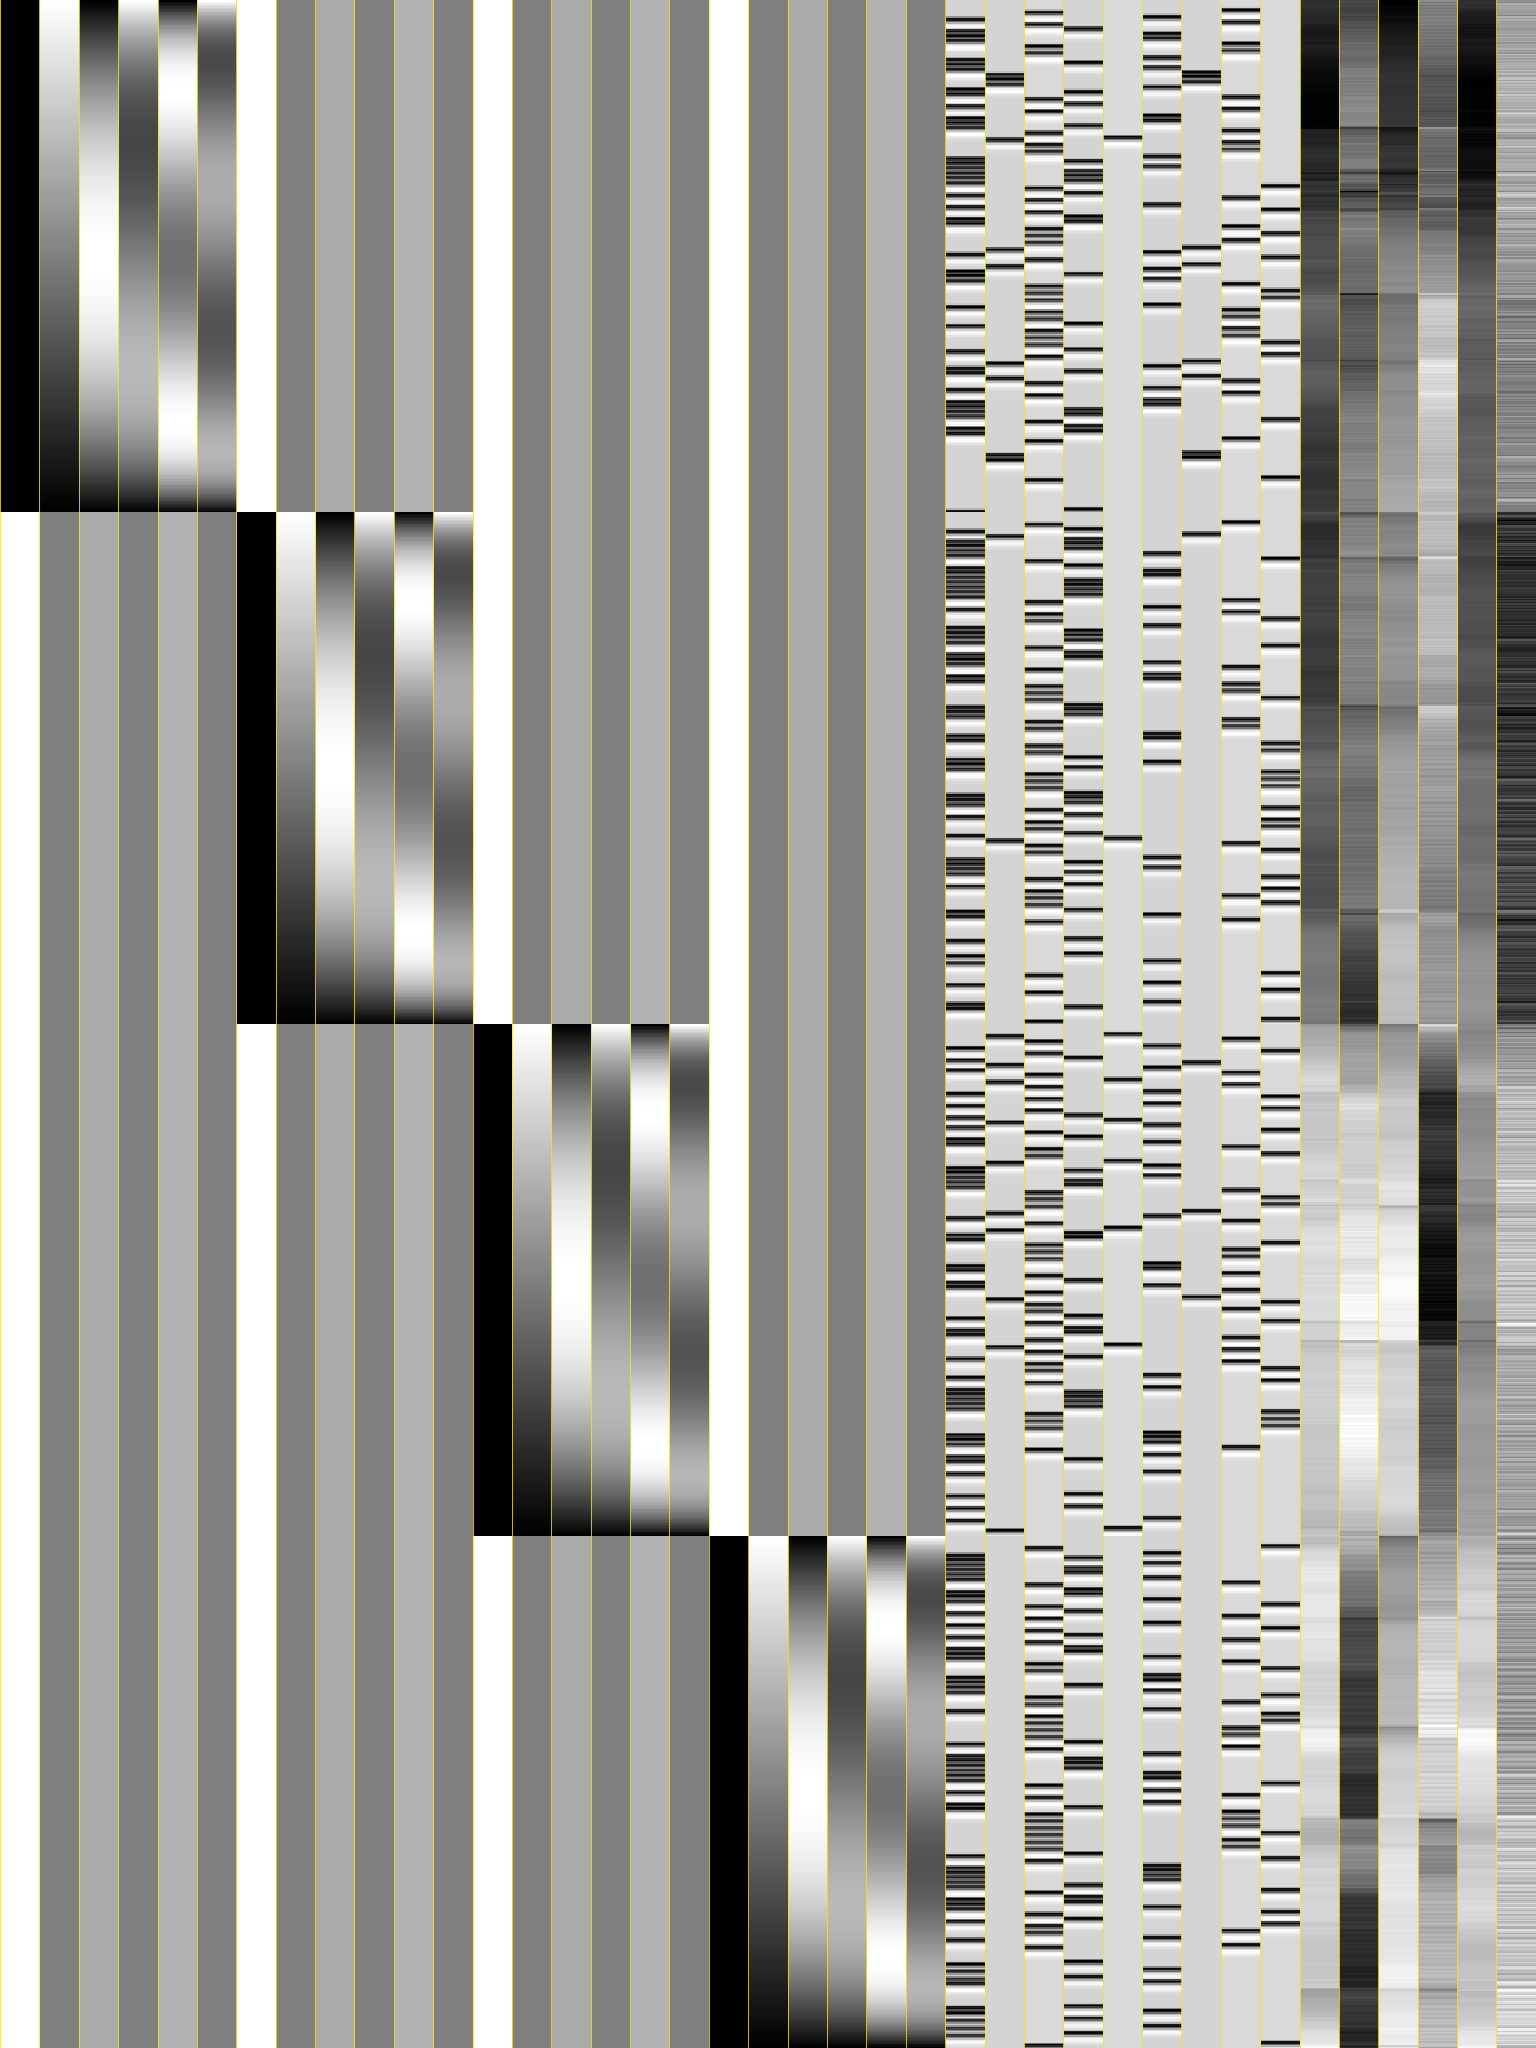

In [18]:
im_task = Image.open(os.path.join(os.getcwd(), 'X.task.jpg'))
im_task

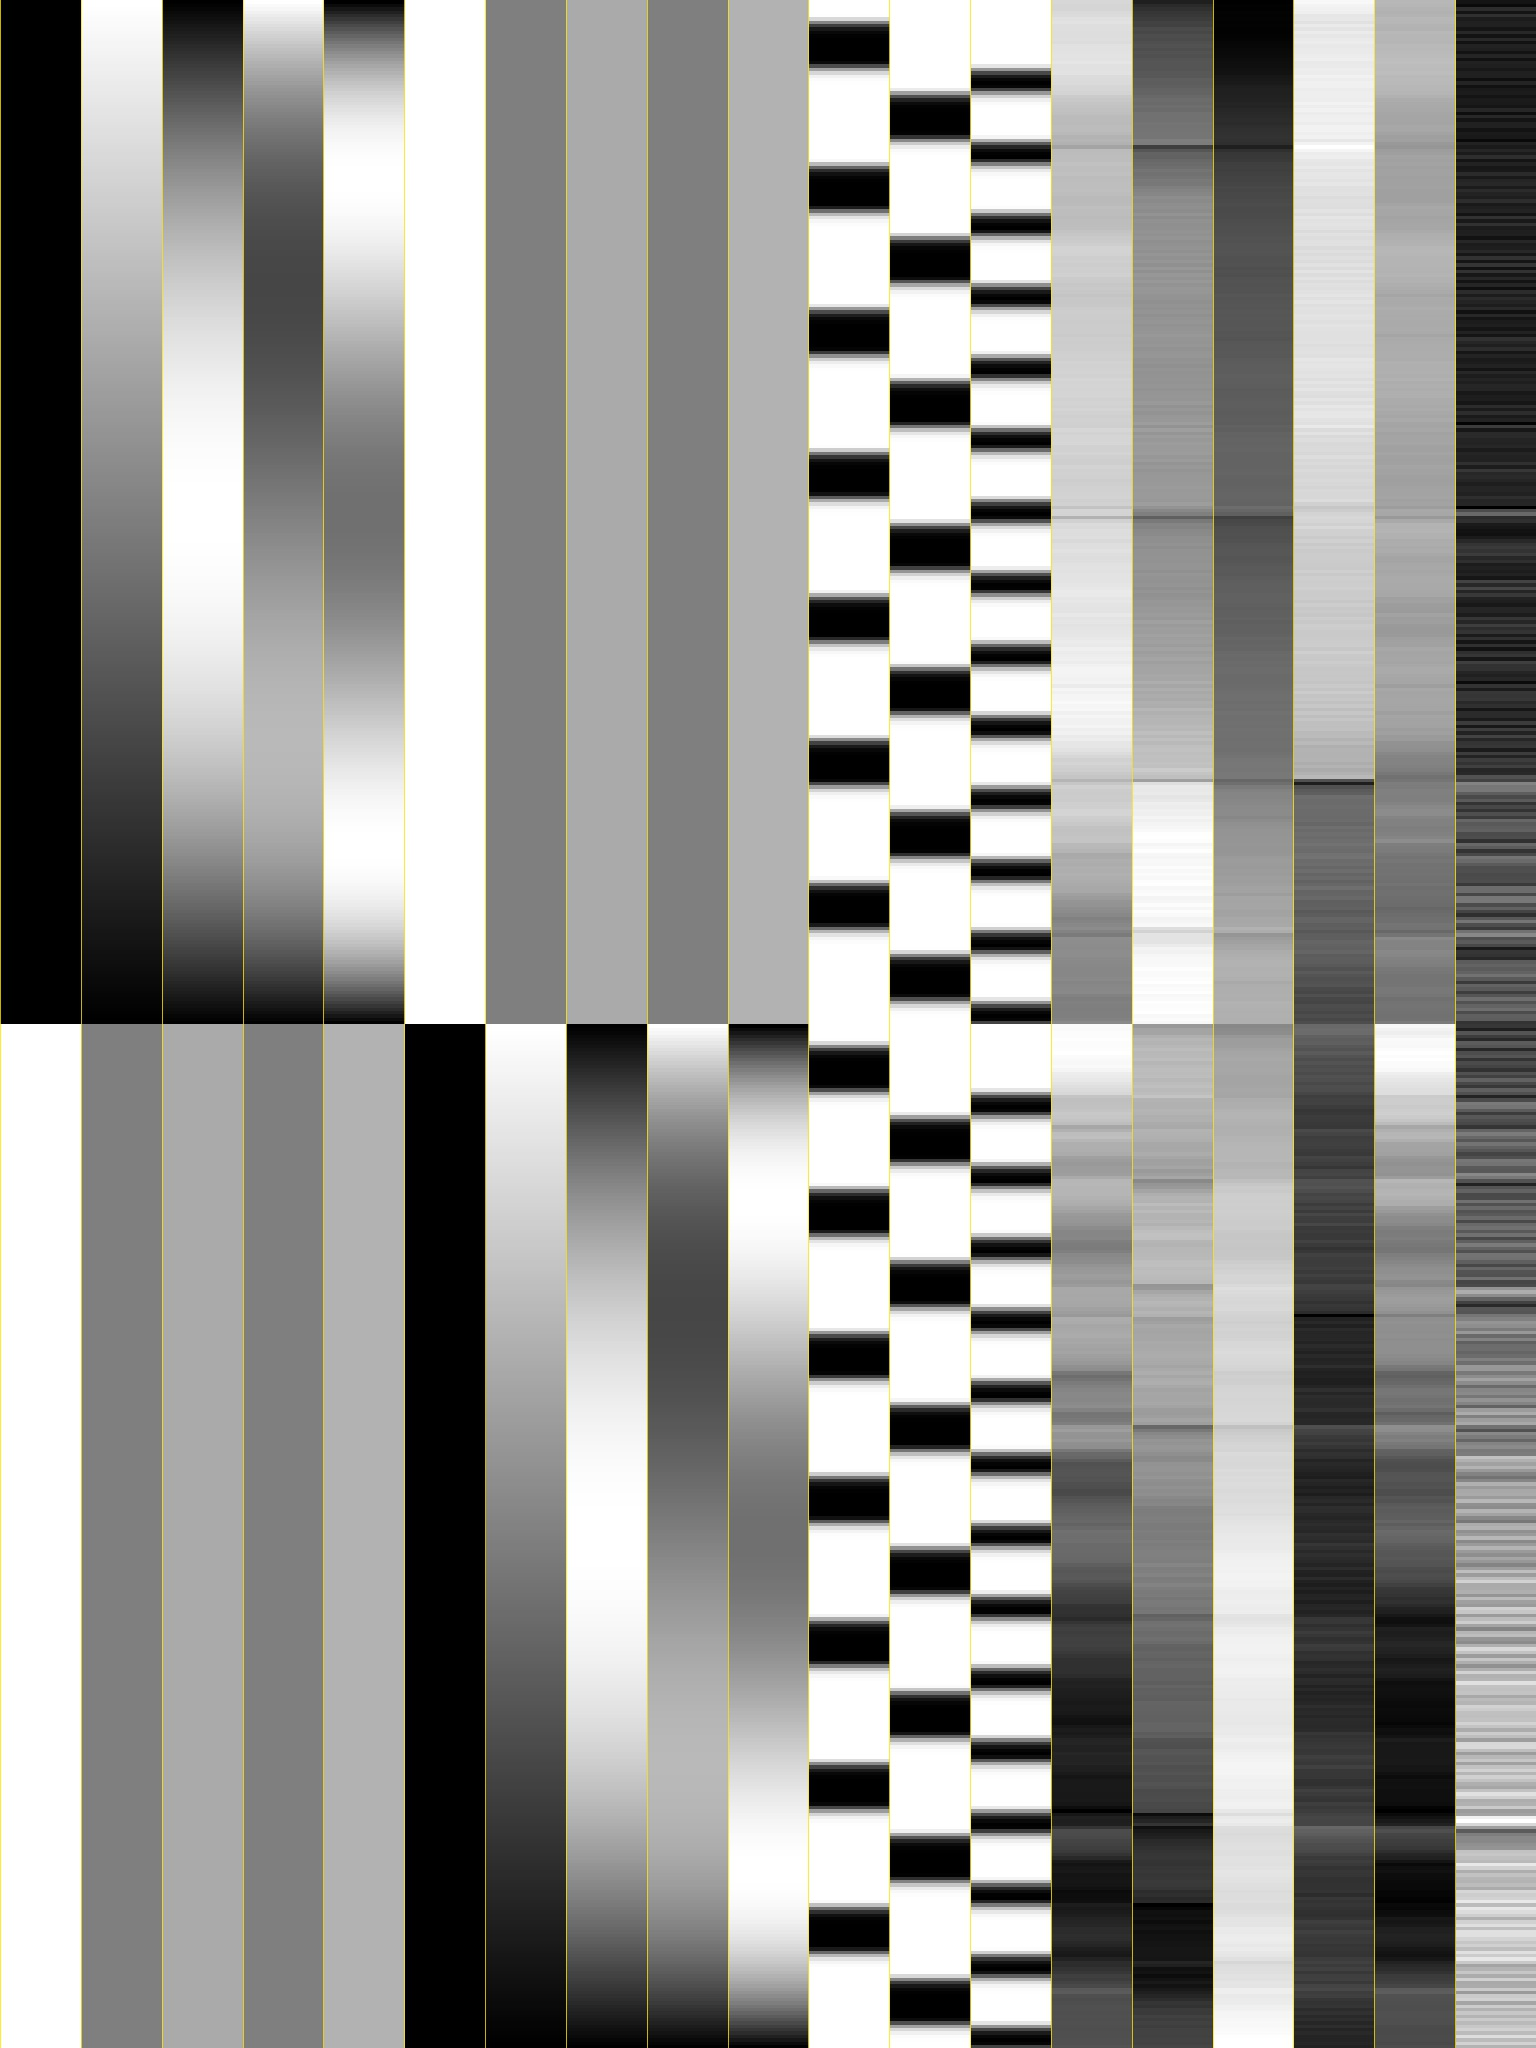

In [35]:
# looks fine I think
im_loc = Image.open(os.path.join(os.getcwd(), 'X.loc.jpg'))
im_loc